<center>
<img src="https://raw.githubusercontent.com/FUlyankin/r_probability/master/end_seminars_2020/sem08/real_expect.png" width="800">

# Домашнее задание 5: АБ-тест
</center>

## Общая информация

__Дата выдачи:__ 07.04.2025

__Дедлайн:__ 23:59MSK 20.04.2025

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from collections import defaultdict

На семинаре мы попытались разобраться как устроена процедура АБ-тестирования. В этом задании мы попытаемся закрепить полученные знания и более аккуратно структурировать их.

### Кратко повторим теорию

Мы хотим выктить новую функциональность на сайте. Перед раскаткой нам хочется проверить, какой эффект мы оказываем на пользователя. Выделим две выборки: тестовую (treatment) и контрольную (control). Тестовой покажем новый сайт. Контрольной старый. Замерим инетерсующую нас метрику, нааример, время проведенной на сайте, в обеих группах:

$$
\begin{aligned}
&X^c_1, \ldots, X^c_{n_c} \sim iid (\mu_c, \sigma^2_c) \\
&X^t_1, \ldots, X^t_{n_t} \sim iid (\mu_t, \sigma^2_t)
\end{aligned}
$$

У выборок есть какие-то математические ожидания, дисперсии. Выборки собраны независимо друг от друга. Если их математические ожидания одинаковые, будем считать, что новая функциональность никак не повлияла на пользователей. Сформулируем это в виде нашей нулевой гипотезы:

$$
\begin{aligned}
&H_0: \hspace{2mm} \mu_c = \mu_t \\
&H_1: \hspace{2mm} \mu_c < \mu_t.
\end{aligned}
$$

Посчитаем по выборке расстояние между математическими ожиданиями $\hat \mu_t - \hat \mu_c$. Оно по ЦПТ имеет нормальное распределение с оценкой дисперсии $\frac{\hat{\sigma}^2_t}{n_t} + \frac{\hat{\sigma}^2_c}{n_c}$. Получается, что

$$
z = \frac{\hat \mu_t - \hat \mu_c}{\sqrt{\frac{\hat{\sigma}^2_t}{n_t} + \frac{\hat{\sigma}^2_c}{n_c}}} \sim N(0,1),
$$

при верности нулевой гипотезы и $n \to \infty$. Если это расстояние оказывается слишком большим, мы отказываемся верить в нулевую гипотезу. Эффект от новой функциональности есть. Будем сравнивать наблюдаемое значение $z$ с $z_{1 - \alpha},$ где уровень значимости $\alpha$ выберем до начала эксперимента.

- Если $z < z_{1 - \alpha},$ нулевая гипотеза не отвергается (похоже, что верна). Расстояние маленькое, разницы нет.
- Если $z > z_{1 - \alpha},$ выбираем альтернативу. У на есть значимый эффект на метрику, от веры в нулевую гипотезу придётся отказаться.

> Ничего не понятно? Тогда вам в лекции. Ниже подборка:  

- [Наша лекция про АБ]( )
- [Неделя про проверку гипотез с курсеры](https://www.youtube.com/watch?v=Zv-5gbJtofk&list=PLCf-cQCe1FRxTgNPwcRSkBjvtE8DEm7rU)


## Задания


__а) [1 балл]__ Реализуйте функцию для проверки гипотезы о равенстве математических ожиданий. Она должна принимать на вход две выборки и выдавать на выход наблюдаемое значение статистики `z_obs` и `p_value` для ситуаций с разными альтернативными гипотезами.

In [2]:
def asy_mean_test(x_control, x_treatment, alternative = 'larger'):
    mean_control = np.mean(x_control)
    mean_treatment = np.mean(x_treatment)

    var_control = np.var(x_control)
    var_treatment = np.var(x_treatment)

    z_obs = (mean_treatment - mean_control) / np.sqrt(var_control / x_control.shape[0] +
                                               var_treatment / x_treatment.shape[0])

    if alternative == 'larger':
        p_value = 1 - stats.norm.cdf(z_obs)
    elif alternative == 'smaller':
        p_value = stats.norm.cdf(z_obs)

    return z_obs, p_value

Если вы написали весь код выше корректно, то строки ниже сработают без проблем.

In [3]:
def gen_sample(n_obs, effect, p_control):
    p_treatment = p_control * (1 + effect)
    x_control = stats.bernoulli(p_control).rvs(n_obs)
    x_treatment = stats.bernoulli(p_treatment).rvs(n_obs)
    return x_control, x_treatment

In [4]:
# Проверка ситуации, когда верна нулевая гипотеза
_, pval = asy_mean_test(*gen_sample(10**5, 0, 0.2))
assert pval > 0.01

In [5]:
# Проверка ситуации, когда верна нулевая гипотеза
_, pval = asy_mean_test(*gen_sample(10**5, 0.1, 0.2))
assert pval < 0.01

Для простоты мы дальше будем работать с односторонней альтернативой и тестом для долей.

$$
\begin{aligned}
&H_0: \hspace{2mm} p_t = p_c \\
&H_1: \hspace{2mm} p_t > p_c
\end{aligned}
$$

__б) [2 балла]__ Предположим, что нулевая гипотеза верна. Как при верности нулевой гипотезы будут распределены `pvalue` и `z_obs`?  

С помощью симуляций сгенерируйте $10^4$ выборок размера $1000$, постройте две гистограммы.

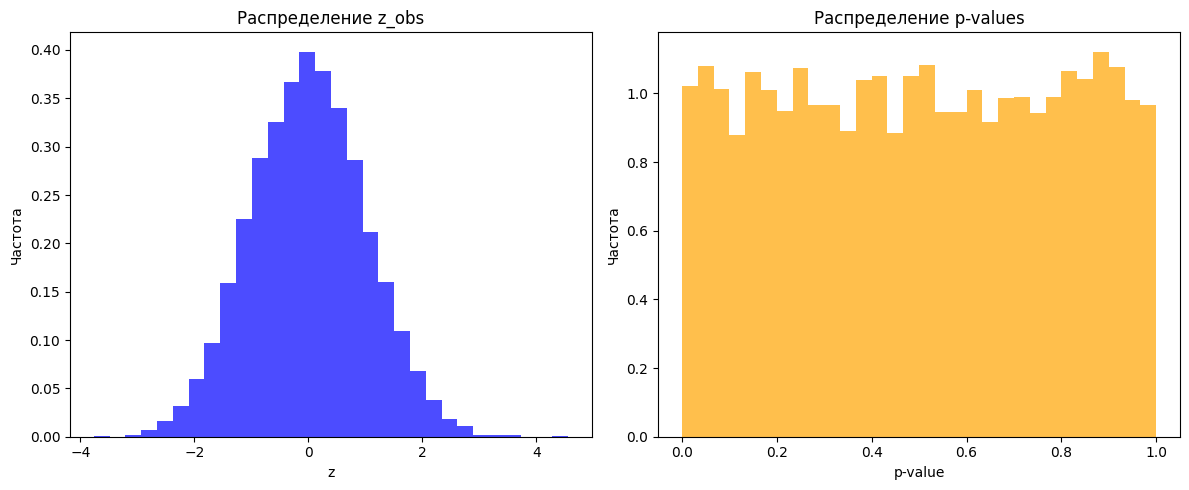

In [6]:
n_samples = 10000
sample_size = 1000

z_obs_list = []
p_value_list = []

for _ in range(n_samples):
    x_control = np.random.normal(loc=60, scale=10, size=sample_size)
    x_treatment = np.random.normal(loc=60, scale=10, size=sample_size)

    z_obs, p_value = asy_mean_test(x_control, x_treatment)

    z_obs_list.append(z_obs)
    p_value_list.append(p_value)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(z_obs_list, bins=30, density=True, alpha=0.7, color='blue')
plt.title('Распределение z_obs')
plt.xlabel('z')
plt.ylabel('Частота')

plt.subplot(1, 2, 2)
plt.hist(p_value_list, bins=30, density=True, alpha=0.7, color='orange')
plt.title('Распределение p-values')
plt.xlabel('p-value')
plt.ylabel('Частота')

plt.tight_layout()
plt.show()

Правда ли, что распределение `pvalue` оказалось равномерным на отрезке $[0;1]$? Какое у распределения `z_obs` математическое ожидание? Попытайтесь понятными словами пояснить, почему распределения оказались именно такими.

__Ответ:__ Распределение p-value действительно оказалось равномерным на отрезке [0, 1]. Это связано с тем, что поскольку мы при генерации выборок не задавали такие условия, при которых нулевая гипотеза должна быть отклонена, вероятность встретить любое p-value распределена равномерно (любое p-value возможно встретить с одинаковой частотой). Вот если бы мы задали условие, что нулевая гипотеза должна быть отклонена (с уровнем статистической значимости 5%), то в этом случае у нас бы основная часть p-value была сосредоточена в диапазоне [0, 0.05] (вероятность получения низких p-значений будет выше).

Относительно распределения z_obs - то у него математическое ожидание равно 0, значения распределены по нормальному закону. В целом это логично поскольку при генерации выборк мы обозначали такие условия, при которых нулевая гипотеза не будет отклонена, логично что разница "средних" по выборкам будет около нулевой.

__в) [1 балл]__ Предположим, что верна альтернативная гипотеза. Доля в тестовой (treatment) выборке оказалась на $20\%$ больше, чем в контрольной. Как при верности нулевой гипотезы будут распределены `pvalue` и `z_obs`?  

С помощью симуляций сгенерируйте $10^4$ выборок размера $1000$, постройте две гистограммы и прокомментируйте получившиеся результаты.

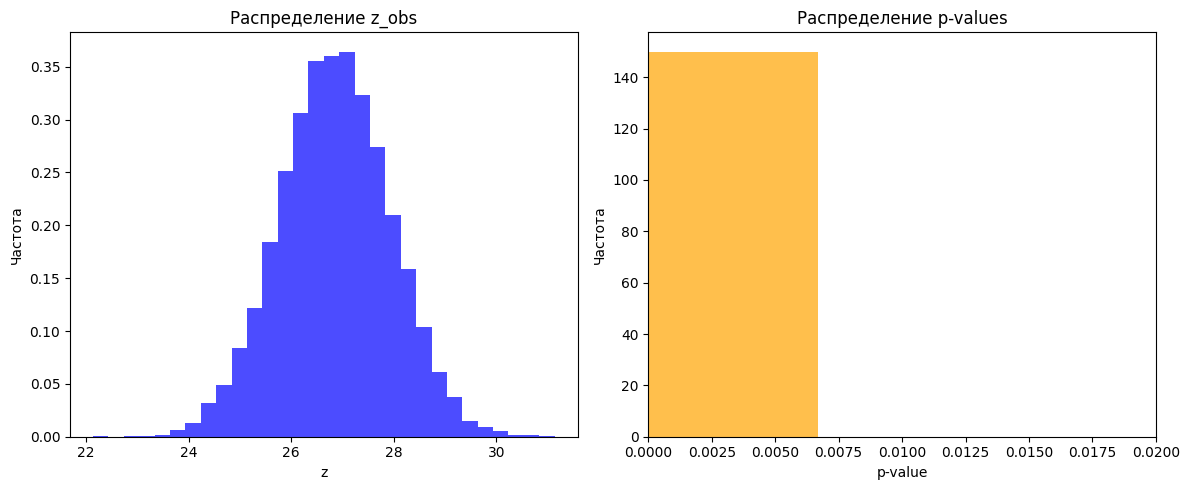

In [7]:
n_samples = 10000
sample_size = 1000

z_obs_values = []
p_value_values = []

for _ in range(n_samples):
    x_control = np.random.normal(loc=60, scale=10, size=sample_size)
    x_treatment = np.random.normal(loc=60 * 1.2, scale=10, size=sample_size) # задаем условия что средние отличаются на 20%

    z_obs, p_value = asy_mean_test(x_control, x_treatment)

    z_obs_values.append(z_obs)
    p_value_values.append(p_value)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(z_obs_values, bins=30, density=True, alpha=0.7, color='blue')
plt.title('Распределение z_obs')
plt.xlabel('z')
plt.ylabel('Частота')

plt.subplot(1, 2, 2)
plt.hist(p_value_values, bins=150, density=True, alpha=0.7, color='orange')
plt.title('Распределение p-values')
plt.xlabel('p-value')
plt.ylabel('Частота')
plt.xlim(0, 0.02)

plt.tight_layout()
plt.show()

__Ответ:__ В этом случае вы видим, что Z распределено относительно математического ожидаения 26-27, а не 0, что при дисперсии z приводит к отклонению нулевой гипотезы. В этому случае p-value оказалось равномерно распределено на отрезке [0, 0.0075] (т.е. значение, соответсвующие отклонению нулевой гипотезы)

А как будут выглядеть результаты, если доля в тестовой выборке больше на $40\%$? Проведите симуляции.

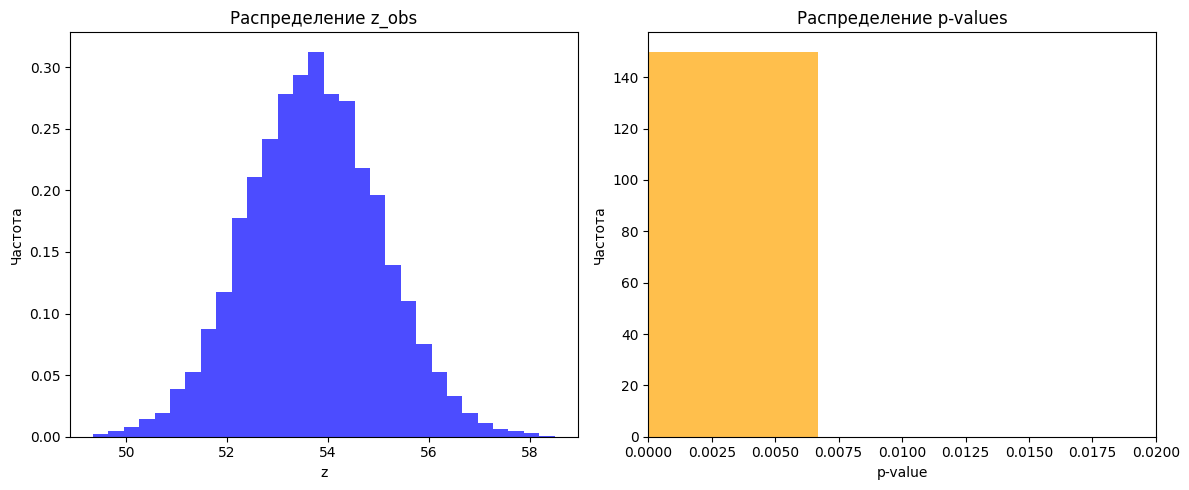

In [8]:
z_obs_values = []
p_value_values = []

for _ in range(n_samples):
    x_control = np.random.normal(loc=60, scale=10, size=sample_size)
    x_treatment = np.random.normal(loc=60 * 1.4, scale=10, size=sample_size) # задаем условия что средние отличаются на 40%

    z_obs, p_value = asy_mean_test(x_control, x_treatment)

    z_obs_values.append(z_obs)
    p_value_values.append(p_value)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(z_obs_values, bins=30, density=True, alpha=0.7, color='blue')
plt.title('Распределение z_obs')
plt.xlabel('z')
plt.ylabel('Частота')

plt.subplot(1, 2, 2)
plt.hist(p_value_values, bins=150, density=True, alpha=0.7, color='orange')
plt.title('Распределение p-values')
plt.xlabel('p-value')
plt.ylabel('Частота')
plt.xlim(0, 0.02)

plt.tight_layout()
plt.show()

__Ответ:__ В целом распределение имеет аналогичную форму, за исключением того, что средняя величина z_obs стала выше.

__г) [1 балл]__ Обычно, перед началом эксперимента, мы фиксируем ошибку первого рода, вероятность отвергнуть нулевую гипотезу, когда она на самом деле верна,  

$$\alpha = \mathbb{P}(H_A \text{ выбрана} \mid H_0 \text{ верна}).$$

Дальше мы принимаем решение, о том, какую гипотезу выбрать, сравнивая `z_obs` с $z_{1 - \alpha},$ либо `pvalue` с $\alpha$ (напомню что мы делаем симуляции для правосторонней альтернативы, поэтому $\alpha$ не надо делить на два).

Давайте проверим для конкретного $\alpha$, что это правда работает. Выберите любое разумное значение $\alpha$. С помощью симуляций сгенерируйте $10^4$ выборок размера $1000$ при верности нулевой гипотезы. Проверьте эти гипотезы и оцените получившееся значение $\alpha$. Правда ли, что оно оказалось равно заявленному значению?

__P.S.__ в идеале, тут надо воспользоваться уже проделанными выше симуляциями.

In [9]:
alpha = 0.05

c = 0

for _ in range(n_samples):
    x_control = np.random.normal(loc=20, scale=15, size=sample_size)
    x_treatment = np.random.normal(loc=20, scale=15, size=sample_size)

    z_obs, p_value = asy_mean_test(x_control, x_treatment)

    if p_value < alpha:
        c += 1

alpha_v = c / n_samples

print(f"Граничное значение alpha: {alpha}")
print(f"Наблюдаемое значение alpha: {alpha_v}")

Граничное значение alpha: 0.05
Наблюдаемое значение alpha: 0.0568


В итоге получили, что наблюдаемое значение alpha ниже теоретического, поэтому нулевая гипотеза отвергается.

Кроме ошибки первого рода есть ещё и ошибка второго рода, вероятность остаться с нулевой гипотезой, когда верна альтернатива,

$$\beta = \mathbb{P}(H_0 \text{ выбрана} \mid H_A \text{ верна}).$$

Давайте предположим, что доля в тестовой (treatment) выборке оказалась на $20\%$ больше, чем в контрольной. С помощью симуляций того же самого объёма оцените, чему равна $\beta$.

__P.S.__ в идеале, тут надо воспользоваться уже проделанными выше симуляциями.

In [10]:
c = 0
c_alt = 0

for _ in range(n_samples):
    x_control = np.random.normal(loc=20, scale=15, size=sample_size)
    x_treatment = np.random.normal(loc=21, scale=15, size=sample_size)

    z_obs, p_value = asy_mean_test(x_control, x_treatment)

    if p_value < alpha:
        c += 1
    else:
        c_alt += 1

beta_n = c_alt / n_samples

print(f"Наблюдаемый уровень (базовый кейс): {beta_n:.4f}")

c = 0
c_alt = 0

for _ in range(n_samples):
    x_control = np.random.normal(loc=20, scale=15, size=sample_size)
    x_treatment = np.random.normal(loc=24, scale=15, size=sample_size)

    z_obs, p_value = asy_mean_test(x_control, x_treatment)

    if p_value < alpha:
        c += 1
    else:
        c_alt += 1

beta_n = c_alt / n_samples

print(f"Наблюдаемый уровень бета (кейс с разницей 20%): {beta_n:.4f}")

Наблюдаемый уровень (базовый кейс): 0.5661
Наблюдаемый уровень бета (кейс с разницей 20%): 0.0000


Теперь доля в тестовой выборке оказалась на $40\%$ больше, чем в контрольной. Чем равна $\beta$ здесь?

In [11]:
c = 0
c_alt = 0

for _ in range(n_samples):
    x_control = np.random.normal(loc=20, scale=15, size=sample_size)
    x_treatment = np.random.normal(loc=28, scale=15, size=sample_size)

    z_obs, p_value = asy_mean_test(x_control, x_treatment)

    if p_value < alpha:
        c += 1
    else:
        c_alt += 1

beta_n = c_alt / n_samples

print(f"Наблюдаемый уровень бета (кейс с разницей 40%): {beta_n:.4f}")

Наблюдаемый уровень бета (кейс с разницей 40%): 0.0000


Что с ошибкой второго рода происходит при росте эффекта? Что происходит с ней, если при проверке гипотезы взять более маленькое $\alpha$?

__Ответ:__ При росте разницы между выборочными средними бета снижается, поскольку выраженный эффект (когда z больше) легче обнаружить, чем когда он невраженный. Соответсвенно, вероятность ошибиться и не признать эффект ниже.

__д) [1 балл]__ Ошибки $\alpha$ и $\beta$ связаны между собой. Чем выше, при фиксированном размере выборки и эффекта мы делаем одну, тем ниже другая. Давайте попробуем в рамках проделанных выше симуляций нарисовать взаимосвязь между ошибками.

Выше, для оценки $\beta$ вы сравнивали вектор `pval` с зафиксированным значением `alpha`.  Переберите `alpha` по циклу от 0 до 1 с шагом 0.01 и оцените для каждого значения `alpha` значение `beta`.

Нарисуйте получившуюся взаимосвязь на графике для эффекта в 20% и 40%. Какая из кривых идёт ниже?

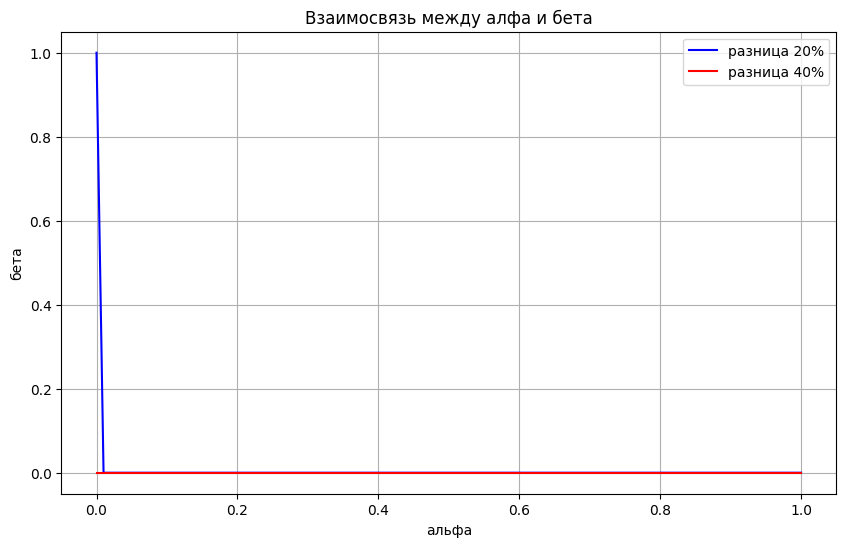

In [12]:
size = 1000
diffs = [0.2, 0.4]
p_val_c = 0.5

alphas = np.arange(0, 1.01, 0.01)
betas_20 = []
betas_40 = []

for alpha in alphas:

    x_control_20, x_treatment_20 = gen_sample(size, diffs[0], p_val_c)
    _, p_value_20 = asy_mean_test(x_control_20, x_treatment_20)

    beta_20 = np.mean(p_value_20 > alpha)
    betas_20.append(beta_20)

    x_control_40, x_treatment_40 = gen_sample(size, diffs[1], p_val_c)
    _, p_value_40 = asy_mean_test(x_control_40, x_treatment_40)

    beta_40 = np.mean(p_value_40 > alpha)
    betas_40.append(beta_40)

plt.figure(figsize=(10,6))
plt.plot(alphas, betas_20, label='разница 20%', color='blue')
plt.plot(alphas, betas_40, label='разница 40%', color='red')
plt.xlabel('альфа')
plt.ylabel('бета')
plt.title('Взаимосвязь между алфа и бета')
plt.legend()
plt.grid()
plt.show()

__Ответ:__ В целом кривые идут примерно на одном уровне,что логично ведь разница 20 и 40% достаточно существенная.

Нарисуйте точно такую же кривую для ситуации, когда была верна нулевая гипотеза.

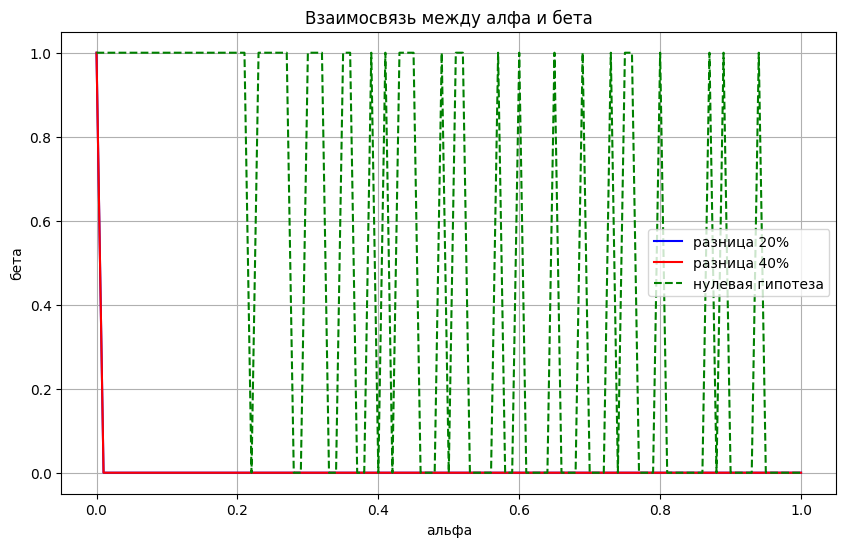

In [13]:
size = 1000
diffs = [0.2, 0.4]
p_val_c = 0.5

alphas = np.arange(0, 1.01, 0.01)
betas_20 = []
betas_40 = []
betas_null_hypothesis = []

for alpha in alphas:
    x_control_20, x_treatment_20 = gen_sample(size, diffs[0], p_val_c)
    _, p_value_20 = asy_mean_test(x_control_20, x_treatment_20)

    beta_20 = np.mean(p_value_20 > alpha)
    betas_20.append(beta_20)

    x_control_40, x_treatment_40 = gen_sample(size, diffs[1], p_val_c)
    _, p_value_40 = asy_mean_test(x_control_40, x_treatment_40)

    beta_40 = np.mean(p_value_40 > alpha)
    betas_40.append(beta_40)

    x_control_null, x_treatment_null = gen_sample(size, 0.0, p_val_c)
    _, p_value_null = asy_mean_test(x_control_null, x_treatment_null)

    beta_null_hypothesis = np.mean(p_value_null > alpha)
    betas_null_hypothesis.append(beta_null_hypothesis)

plt.figure(figsize=(10,6))
plt.plot(alphas, betas_20, label='разница 20%', color='blue')
plt.plot(alphas, betas_40, label='разница 40%', color='red')
plt.plot(alphas, betas_null_hypothesis, label='нулевая гипотеза', color='green', linestyle='--')
plt.xlabel('альфа')
plt.ylabel('бета')
plt.title('Взаимосвязь между алфа и бета')
plt.legend()
plt.grid()
plt.show()

Такая форма графика может быть связана с тем, что z слишком велико и бета принимает значение либо 0 либо 1. При этом отмечаю, что чем выше альфа, тем реже встречается бета = 1 и чаще равно 0, что говорит о том, что при росте альфа беа снижается.

Вместо осей $(\alpha, \beta)$ обычно такой график рисуют в осях $(\alpha, 1 - \beta)$. Давайте построим его и проинтерпретируем.

In [14]:
def plot_pvalue_distribution(dict_pvalues):
    xseq = np.linspace(0, 1, 1000)

    for key, pvalues in dict_pvalues.items():
        yseq = [np.mean(pvalues < x) for x in xseq]
        plt.plot(xseq, yseq, label=key)

    plt.plot([0, 1], [0, 1], '--k', alpha=0.8)
    plt.title('Распределение p-value/ROC-кривая', size=16)
    plt.xlabel('alpha', size=12)
    plt.ylabel('1 - beta', size=12)
    plt.legend(fontsize=12)
    plt.grid()

Заполните пропуски в коде ниже, чтобы для нашего АБ-теста отрисовались ROC-кривые.

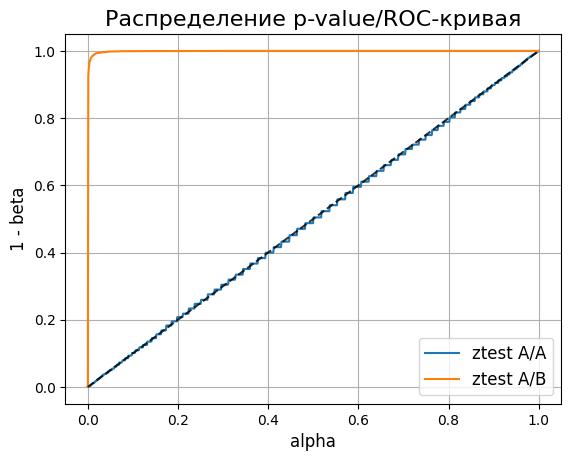

In [15]:
n_sim = 10**4
sample_size = 1000
prob = 0.5
effect_size = 0.2

p_values = defaultdict(list)

for _ in range(n_sim):
    x_control, x_treatment = gen_sample(sample_size, effect_size, prob)
    z_obs_ab, pval_ab = asy_mean_test(x_control, x_treatment)

    x_control_again, _ = gen_sample(sample_size, 0.0, prob)
    z_obs_aa, pval_aa = asy_mean_test(x_control, x_control_again)

    p_values['ztest A/A'].append(pval_aa)
    p_values['ztest A/B'].append(pval_ab)

plot_pvalue_distribution(p_values)
plt.show()

В целом такой вид ROC кривой ожидаем с учетом предыдущих графиков. Попробуем уменьшить величину эффекта и посмотреть как будет выглядеть ROC кривая в этом случае

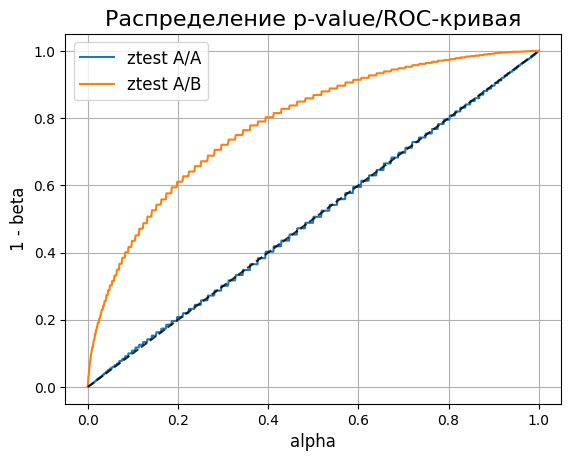

In [16]:
n_sim = 10**4
sample_size = 1000
prob = 0.5
effect_size = 0.05

p_values = defaultdict(list)

for _ in range(n_sim):
    x_control, x_treatment = gen_sample(sample_size, effect_size, prob)
    z_obs_ab, pval_ab = asy_mean_test(x_control, x_treatment)

    x_control_again, _ = gen_sample(sample_size, 0.0, prob)
    z_obs_aa, pval_aa = asy_mean_test(x_control, x_control_again)

    p_values['ztest A/A'].append(pval_aa)
    p_values['ztest A/B'].append(pval_ab)

plot_pvalue_distribution(p_values)
plt.show()

Получившийся график можно проинтерпретировать двумя способами. Мы много-много раз проводим АБ-тест. В начале теста мы зафиксировали какую-то $\alpha$ и дальше проверяем кучу гипотез.

1. Линия `ztest A/A` это функция распределения pvalue при верности нулевой гипотезы. Оно было равномерным, мы двигаем $\alpha$ по оси $OX$ и оцениваем $\mathbb{P}(\text{pvalue} \le \alpha) = F(\alpha)$.  

По аналогии, линия `ztest A/B` это функция распределения pvalue при верности альтернативной гипотезы.

2. Линию `ztest A/B` можно проинтерпретировать как ROC-кривую. Если вы уже знаете про задачу классификации из машинного обучения, то это ровно оно. Полнота это $1 - \beta$, то есть то, сколько верных альтернативных гипотез мы найдём, если будем использовать наш АБ-тест, FPR это $\alpha$, то есть то, сколько верных нулевых гипотез мы заберём с собой в альтернативные. Эту величину мы определяем до старта эксперимента.

> Важно: если вы не поняли интерпретацию из пункта 2, просто забейте. Заботаете МО, поймёте. Интерпретацию из пункта 1 должны понять все. Если вы её не поняли, время напрячься и подумать ещё разок.

__Что для нас важно:__

- Чем выпуклее график, тем лучше мы находим эффект и процедура проверки гипотезы работае корректно;
- Чем больше у нас наблюдений тем выпуклее график;
- Чем сильнее в тестовой выборке подскакивает $p_t$ при изменениях, тем легче нам найти эффект и тем выпуклее график;
- Если $p_t$ подскочило на очень маленькую величину, нам сложнее найти это изменение, и график будет менее выпуклым;
- Чем меньше в выборках дисперсия, тем выпуклее график.

__е) [2 балла]__ При верности альтернативной гипотезы, постройте ROC-кривые из пункта выше для разного числа наблюдений в выборке: 10, 100, 1000, 10000 при любом фиксированном эффекте.

C:\Users\Kulitskov\AppData\Local\Temp\ipykernel_20360\979211991.py:8: RuntimeWarning: divide by zero encountered in scalar divide
  z_obs = (mean_treatment - mean_control) / np.sqrt(var_control / x_control.shape[0] +


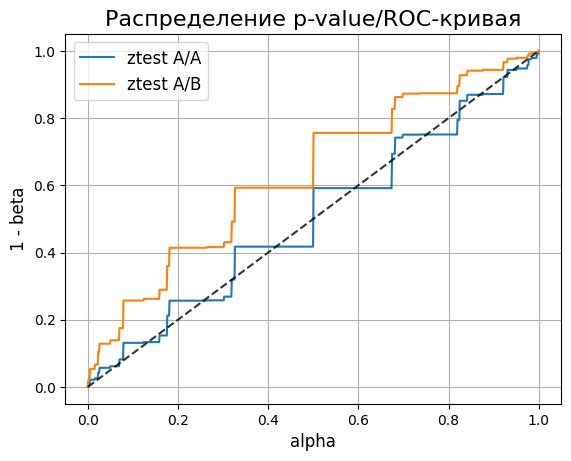

In [17]:
n_sim = 10**4
sample_size = 10
prob = 0.5
effect_size = 0.2

p_values = defaultdict(list)

for _ in range(n_sim):
    x_control, x_treatment = gen_sample(sample_size, effect_size, prob)
    z_obs_ab, pval_ab = asy_mean_test(x_control, x_treatment)

    x_control_again, _ = gen_sample(sample_size, 0.0, prob)
    z_obs_aa, pval_aa = asy_mean_test(x_control, x_control_again)

    p_values['ztest A/A'].append(pval_aa)
    p_values['ztest A/B'].append(pval_ab)

plot_pvalue_distribution(p_values)
plt.show()

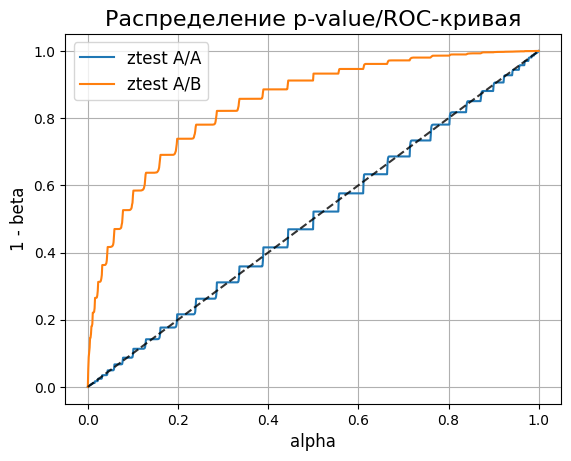

In [18]:
n_sim = 10**4
sample_size = 100
prob = 0.5
effect_size = 0.2

p_values = defaultdict(list)

for _ in range(n_sim):
    x_control, x_treatment = gen_sample(sample_size, effect_size, prob)
    z_obs_ab, pval_ab = asy_mean_test(x_control, x_treatment)

    x_control_again, _ = gen_sample(sample_size, 0.0, prob)
    z_obs_aa, pval_aa = asy_mean_test(x_control, x_control_again)

    p_values['ztest A/A'].append(pval_aa)
    p_values['ztest A/B'].append(pval_ab)

plot_pvalue_distribution(p_values)
plt.show()

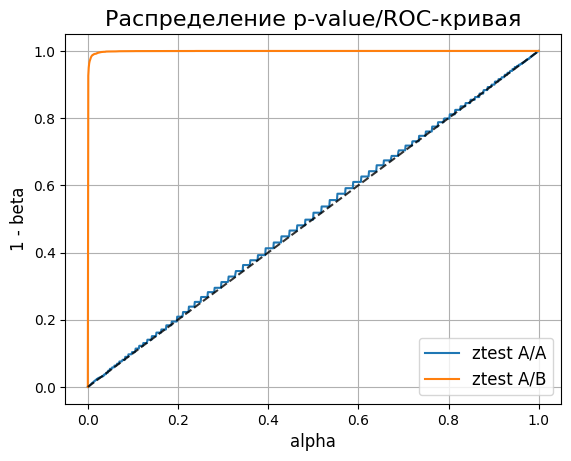

In [19]:
n_sim = 10**4
sample_size = 1000
prob = 0.5
effect_size = 0.2

p_values = defaultdict(list)

for _ in range(n_sim):
    x_control, x_treatment = gen_sample(sample_size, effect_size, prob)
    z_obs_ab, pval_ab = asy_mean_test(x_control, x_treatment)

    x_control_again, _ = gen_sample(sample_size, 0.0, prob)
    z_obs_aa, pval_aa = asy_mean_test(x_control, x_control_again)

    p_values['ztest A/A'].append(pval_aa)
    p_values['ztest A/B'].append(pval_ab)

plot_pvalue_distribution(p_values)
plt.show()

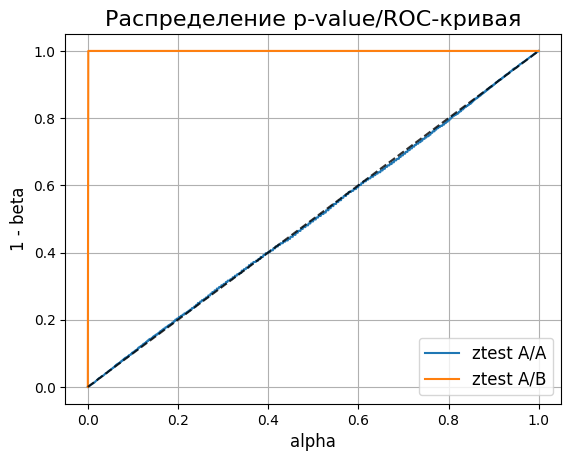

In [20]:
n_sim = 10**4
sample_size = 10000
prob = 0.5
effect_size = 0.2

p_values = defaultdict(list)

for _ in range(n_sim):
    x_control, x_treatment = gen_sample(sample_size, effect_size, prob)
    z_obs_ab, pval_ab = asy_mean_test(x_control, x_treatment)

    x_control_again, _ = gen_sample(sample_size, 0.0, prob)
    z_obs_aa, pval_aa = asy_mean_test(x_control, x_control_again)

    p_values['ztest A/A'].append(pval_aa)
    p_values['ztest A/B'].append(pval_ab)

plot_pvalue_distribution(p_values)
plt.show()

__Ответ:__ На выборке 10 наблюдений видим пилообразный графки А/А теста. Это связано с тем, что построение для 10 наблюдений равномерного распределения затруднительно: шаг для каждого из 10 налюдений будет 10%, в связи с чем альфа будет расти быстрее,чем накапливаться нужный процент наблюдений при котором не отклоняется нулевая гипотеза. На болшом количестве наблюдений значение кривой стабилизируется.

__ё) [1 балл]__ Количество наблюдений, ошибка 1 и 2 рода, размер эффекта, который мы ищем и дисперсия в выборках связаны между собой. Для некоторых критериев проверки гипотез можно вывести формулы, которые их связывают.

В данном случае, формула для расчета числа наблюдений _для одной группы_ выглядит вот так:

$$
n_{\text{one group}} = \frac{(\sigma_A^2 + \sigma_B^2) \cdot (z_{1-\frac{\alpha}{2}} + z_{1-\beta})^2}{MDE^2},
$$

In [21]:
def calculate_n(sigma_a, sigma_b, alpha, beta, MDE) -> int:
  z_alpha = stats.norm.ppf(1 - alpha / 2)
  z_beta = stats.norm.ppf(1 - beta)
  return round((sigma_a ** 2 + sigma_b ** 2) * (z_alpha + z_beta) / (MDE ** 2))

В приложении Яндекс.Такси в конце поездки вылезают рандомные опросники. В одном из опросников задаётся вопрос «А вы пристёгивались, когда ехали?»

В России, в день, в Такси происходит 1 миллион заказов. Вопрос про ремни задаётся рандомным 10% пользователей, закончивших поездку. Пользователь не игнорирует опросник и отвечает на него да или нет с вероятностью 5% (цифры взяты из головы и не отражают реальную статистику).

Менеджер Екатерина хочет сделать так, чтобы когда пассажир садится в машину, Алиса просила его пристегнуться. Хочется замерить, какой эффект это даст на пристёгивания. Станут ли люди чаще пристёгиваться. Замерять мы это будем опросником. Сейчас 10% пользователей говорят, что пристегнулись.

Екатерина пришла к вам и между вами состоялся следующий диалог:

- Хочу АБ-тест с разбивкой 50 на 50.
- Какие ошибки 1 и 2 рода хочешь?
- Нулевые.
- Нам надо бесконечно наблюдений, готова столько ждать?
- Нет.
- На сколько мы хотим, чтобы выросла доля ответов да?
- Если подрастёт хотябы на процент, будет круто.
- То есть если меньше процента, такой эффект считаем неудачей и отсутствием изменения?
- Да.
- Давай я нарисую тебе табличку с разными ошибками, а внутри на пересечении напишу сколько дней надо ждать, чтобы найти такой минимальный эффект.
- Давай, по ней и примем решение.

Нарисуйте для Екатерины такую табличку. Не забудьте перевести общее количество наблюдений в дни.

In [22]:
import pandas as pd

sigma_a = 5
sigma_b = 5
MDE = 0.01

alpha_val = [0.01, 0.05, 0.1]
beta_val = [0.05, 0.1, 0.2, 0.3, 0.4]

res = []

for alpha in alpha_val:
    for beta in beta_val:
        n = calculate_n(sigma_a, sigma_b, alpha, beta, MDE)
        days = round(n / (1000000*0.05))
        res.append({'ошибка_1_рода': alpha, 'ошибка_2_рода': beta, 'дней_наблюдения': days})

res = pd.DataFrame(res)

pivot_table = res.pivot(index='ошибка_2_рода', columns='ошибка_1_рода', values='дней_наблюдения')

pivot_table

ошибка_1_рода,0.01,0.05,0.10
ошибка_2_рода,,,
0.05,42,36,33
0.10,39,32,29
0.20,34,28,25
0.30,31,25,22
0.40,28,22,19


__ж) [1 балл]__ Попробуем сломать наш АБ-тест. Когда мы используем z-тест, мы размышляем в терминах центральной предельной теоремы. Тест будет работать, если выполнены предпосылки ЦПТ:

- Наблюдения независимо одинаково распределены
- В данных нет выборосов, дисперсия конечная
- Данных много

Давайте сломаем одно из условий и попробуем собрать выборку из [распределения Парето](https://ru.wikipedia.org/wiki/Распределение_Парето).

In [23]:
def gen_sample(n_obs, effect, b=0.5):
    x_control = stats.pareto(b=b).rvs(n_obs)
    x_treatment = stats.pareto(b=b).rvs(n_obs)
    x_treatment = (1 + effect) * x_treatment
    return x_control, x_treatment

Отрисуйте ROC-кривые для $b=3$, $b=1$, $b=0.5$

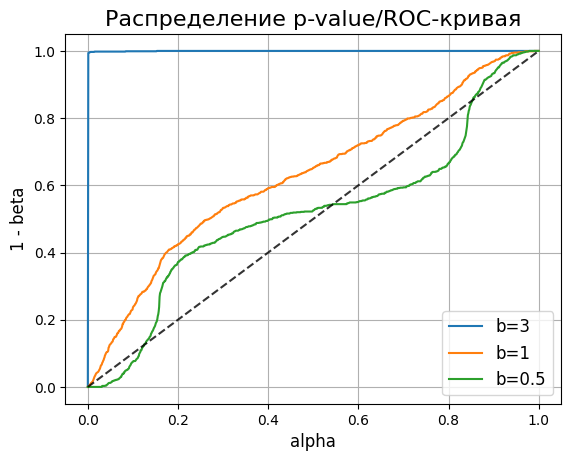

In [24]:
n_sim = 1000
sample_size = 1000
effect_size = 0.2

b_values = [3, 1, 0.5]
dict_pvalues = {}

for b in b_values:
    pvals_ab = []

    for _ in range(n_sim):
        x_control, x_treatment = gen_sample(sample_size, effect_size, b)
        _, pval_ab = asy_mean_test(x_control, x_treatment)
        pvals_ab.append(pval_ab)

    dict_pvalues[f'b={b}'] = pvals_ab

plot_pvalue_distribution(dict_pvalues)
plt.show()

__Ответ:__ В целом видно, что А/А тест указывает на проблемы с данными (вместо ровной околодиагональной линиии, характерной для равномрного распределения, мы получили сильно колеблющуюся). Сломать А/А тест удалось.

Возьмите при каждом $b$ одну выборку, нарисуйте для неё гистограмму и посмотрите как обстоят дела с выбросами.

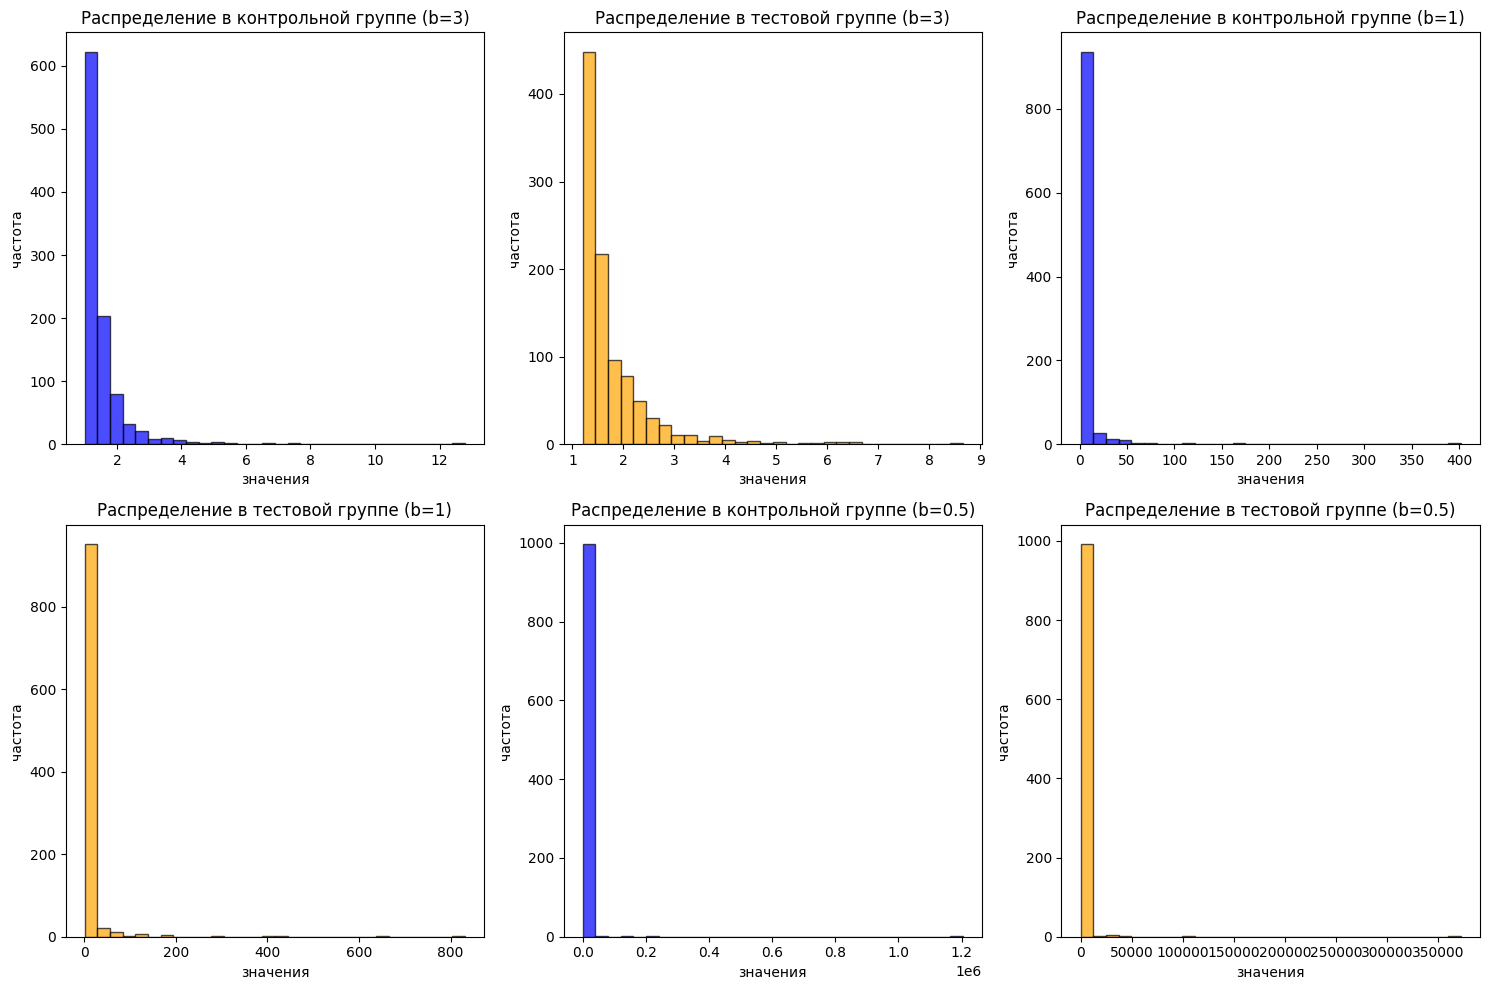

In [25]:
n_obs = 1000
effect_size = 0.2
b_values = [3, 1, 0.5]

plt.figure(figsize=(15, 10))

for i, b in enumerate(b_values):
    x_control, x_treatment = gen_sample(n_obs, effect_size, b)

    plt.subplot(2, 3, i * 2 + 1)
    plt.hist(x_control, bins=30, alpha=0.7, color='blue', edgecolor='black')
    plt.title(f'Распределение в контрольной группе (b={b})')
    plt.xlabel('значения')
    plt.ylabel('частота')

    plt.subplot(2, 3, i * 2 + 2)
    plt.hist(x_treatment, bins=30, alpha=0.7, color='orange', edgecolor='black')
    plt.title(f'Распределение в тестовой группе (b={b})')
    plt.xlabel('значения')
    plt.ylabel('частота')

plt.tight_layout()
plt.show()

__Ответ:__ Видим, что распределение значений имеет множество выбросов. По всей видимости это причина расхождения А/А теста.

У распределения Парето не всегда существует дисперсия. Это ломает предпосылки ЦПТ и АБ-тест разваливается.

Возникает вполне резонный вопрос: а что делать в таких ситуациях? Есть несколько дорог.

- Во-первых, можно отвязаться от математического ожидания и поработать с медианой. Для неё тоже можно вывести асимптотическое распределение с помощью дельта-метода.
- Во-вторых, можно попробовать другие техники проверки гипотез. Например, бутстрап и непараметрические критерии.

Об этом мы и будем говорить на следующих парах.